In [34]:
import os
import pandas as pd
import datetime
import calendar
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import requests as r
from bs4 import BeautifulSoup
import re
import time
from code.company_data_pipeline import *

%matplotlib inline

In [2]:
PROJECT_HOME = "/Users/Brian/workplace/galvanize/gdelt_project/"

data_dir = "/Users/Brian/Data/gdelt/raw/"
data_file = "201512_h_all_txt.zip"
freq = 'hourly'
region = 'us'

In [3]:
def get_timestamp(s):
    '''
    Translates a string that looks like "%Y-%m-%dT%H:%M:%S" and is already in gmt
    into a timestamp
    '''
    d = datetime.datetime.strptime(s, "%Y-%m-%dT%H:%M:%S")
    return calendar.timegm(d.timetuple())

In [4]:
# This returns fast if the data is already unzipped.  
# Not sure if it will work or not when we have a different archive
# with more recent but overlapping data
current_dir = os.getcwd()
os.chdir(data_dir)
os.system("unzip " + data_dir + data_file)

256

In [5]:
g = os.walk(data_dir + 'data/' + freq + '/' + region)
g.next()
x = g.next()
count = 0
limit = 1000
series = []

for triple in g:
    for filename in triple[2]:
        try:
            symbol = filename.split('.')[0]
            path = '/'.join([triple[0], filename])

            df = pd.read_csv(path)
            df['timestamp'] = (df['Date'] + 'T' + df['Time']).apply(get_timestamp)
            df = df.set_index(['timestamp'])
            df[symbol] = df.Open
            series.append(df[symbol])
        except Exception:
            # It seems that this is rare.  Not part of MVP if important at all.
            # fuck it
            pass
        count += 1
        if count >= limit:
            break;
    if count >= limit:
        break;
len(series)

# TODO: Consider dropping stocks that have too many missing values

994

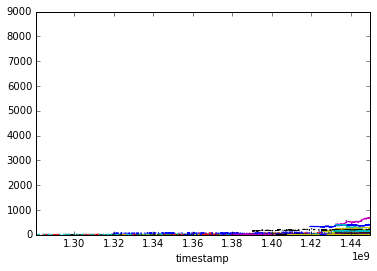

In [6]:
# Data! Horray!
df = pd.DataFrame(data=series).T
df.plot(legend=False)

In [7]:
# Deal with missing values
df = df.interpolate().fillna(method='bfill')

In [8]:
# Looks like a small number of stocks go back considerably further than the rest.  
# Conjecture is that the archive is willing to go back further because they have fewer
# data points to keep track of.  This is bad for us because it means our data frame is full
# of NAs.  Let's take the p50 starting point as our starting point and cut off anything before
# that.  

# Quick hack
df = df[df.index > 1433000000]

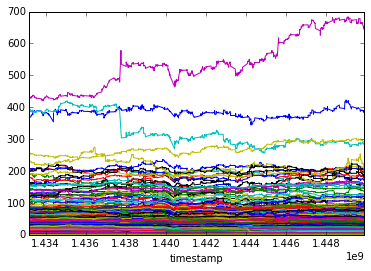

In [9]:
df.plot(legend=False)

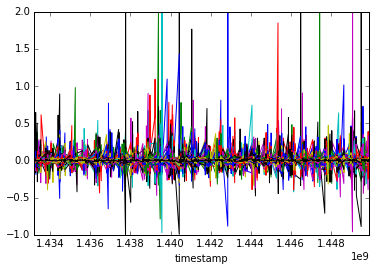

In [10]:
dif_df = df.pct_change().clip(-2, 2).fillna(0.)
dif_df.plot(legend=False)

In [11]:
# X[0] is now NAs because we diffed
X = dif_df.values
X

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,  -3.77180575e-03,   2.62474081e-05, ...,
         -1.97044335e-02,   1.05263158e-02,   7.72698004e-03],
       [  0.00000000e+00,  -1.18315192e-03,  -1.99475066e-03, ...,
         -2.01005025e-02,   0.00000000e+00,   1.78913738e-03],
       ..., 
       [  6.45380435e-03,  -6.52680653e-03,   4.21229992e-04, ...,
         -8.31600832e-03,   2.25988701e-02,  -5.21920668e-03],
       [  3.71245359e-03,   1.64242140e-03,  -1.26315789e-02, ...,
          6.28930818e-03,   0.00000000e+00,   1.19359916e-02],
       [  3.02622730e-03,  -5.62192551e-03,  -1.27931770e-02, ...,
          1.14583333e-02,   3.86740331e-02,  -9.20285159e-03]])

In [12]:
pca = PCA(n_components=5)
pca.fit(X)

PCA(copy=True, n_components=5, whiten=False)

In [13]:
component = 0

idx = np.argsort(pca.components_[component])[:20]
# This is biotech. Also amazon.  We're currently measuring absolute change though, not
# relative change
print df.columns[idx]
print np.sort(pca.components_[component])[:20]

Index([u'cbio', u'bpfhw', u'cadtr', u'eses', u'esea', u'ahpi', u'bosc',
       u'crdc', u'esmc', u'csbr', u'daio', u'amrk', u'ctib', u'axpww', u'chnr',
       u'bhacw', u'bhacr', u'bva', u'cfbk', u'axsm'],
      dtype='object')
[-0.26302171 -0.05128837 -0.01163875 -0.00766254 -0.0076423  -0.00661195
 -0.00635621 -0.00493901 -0.00488062 -0.00478254 -0.00466012 -0.00409179
 -0.00302248 -0.00260523 -0.00230939 -0.00177598 -0.00164107 -0.00151975
 -0.00141402 -0.00129263]


In [14]:
component = 1

idx = np.argsort(pca.components_[component])[:10]
# This is biotech. Also amazon.  We're currently measuring absolute change though, not
# relative change
print df.columns[idx]
print np.sort(pca.components_[component])[:10]

Index([u'agfsw', u'bpfhw', u'exfo', u'dsky', u'cambw', u'abdc', u'chop',
       u'arci', u'aktx', u'aplp'],
      dtype='object')
[-0.52538381 -0.13302126 -0.08781979 -0.05390716 -0.04687867 -0.04543332
 -0.04241946 -0.03958372 -0.03901777 -0.03770958]


In [15]:
component = 2

idx = np.argsort(pca.components_[component])[:10]
# This is biotech. Also amazon.  We're currently measuring absolute change though, not
# relative change
print df.columns[idx]
print np.sort(pca.components_[component])[:10]

Index([u'cyhhz', u'asti', u'coyn', u'dwch', u'aqxp', u'cccr', u'delt', u'bnso',
       u'aeti', u'cmls'],
      dtype='object')
[-0.19780872 -0.18718528 -0.09073225 -0.06393883 -0.06218322 -0.05795846
 -0.04896523 -0.04733368 -0.04300456 -0.0404835 ]


In [16]:
component = 3

idx = np.argsort(pca.components_[component])[:10]
# This is biotech. Also amazon.  We're currently measuring absolute change though, not
# relative change
print df.columns[idx]
print np.sort(pca.components_[component])[:10]

Index([u'axpw', u'bpfhw', u'axpww', u'bntcw', u'asti', u'dxm', u'dwch',
       u'aeri', u'ers', u'bhacr'],
      dtype='object')
[-0.62638278 -0.51373663 -0.14839721 -0.10541666 -0.08070506 -0.07716935
 -0.07491116 -0.05629856 -0.05155715 -0.04207067]


In [17]:
idx2 = np.argsort(pca.components_[1])[:10]
df.columns[idx2]

Index([u'agfsw', u'bpfhw', u'exfo', u'dsky', u'cambw', u'abdc', u'chop',
       u'arci', u'aktx', u'aplp'],
      dtype='object')

In [18]:
idx3 = np.argsort(pca.components_[3])[:10]
df.columns[idx3]

Index([u'axpw', u'bpfhw', u'axpww', u'bntcw', u'asti', u'dxm', u'dwch',
       u'aeri', u'ers', u'bhacr'],
      dtype='object')

In [19]:
# For nasdaq stocks the following always seems to have a text description
# of the company.  
# http://www.nasdaq.com/symbol/espr
# Perform tfidf analylsis on ALL company descriptions.  Then we can take the mean 
# for the top and bottom companies in each component.
# Get all the ticker symbols from nasdaq dir, do scraping, 

In [20]:
get_nasdaq_desc("axpw")

'The primary business of Axion Power International, Inc. (the "Company", Axion, "we", "our", or "us") is to develop, design, manufacture and sell advanced energy storage devices, components and systems that are based on our patented PbC\xc2\xae technology. We also manufacture standard and specialty lead-acid batteries. Our PbC batteries and battery components, which are manufactured primarily through the use of activated carbon as an alternative to lead in the battery\'s negative electrode, have application to varied energy system storage functions.     The Energy Storage Industry     The energy storage industry has traditionally been based on battery, flywheel, capacitor, thermal, chemical systems, power to gas, gravity, pumped storage hydroelectricity, and compressed air systems, to provide a temporary or back-up source for energy.&nbsp;&nbsp;... '

In [30]:
write_company_description_file(100)

In [35]:
with open(PROJECT_HOME + 'data/company/nasdaq_descriptions.tsv') as f:
    company_df = pd.read_csv(f, 
                         sep='\t', 
                         header=None)
company_df[0].iloc[-1]

'zyne'

In [36]:
company_df

,0,1
0,aaap,We are an innovative radiopharmaceutical compa...
1,aal,"American Airlines Group Inc. (AAG), a Delaware..."
2,aame,"Atlantic American Corporation, a Georgia corpo..."
3,aaoi,This report contains forward-looking statement...
4,aaon,"AAON, Inc., a Nevada corporation, (""AAON Nevad..."
5,aaon,"AAON, Inc., a Nevada corporation, (""AAON Nevad..."
6,aapc,We are a newly organized blank check company i...
7,aapl,NaN
8,aavl,We are a clinical-stage biotechnology company ...
9,aaww,The following represents terms and statistics ...
